# QMSS Projects in Advanced Machine Learning Assignment 2: Covid Positive X-Rays 


This  is my submission for the second assignment for QMSS Projects in Advanced Machine Learning. This notebook contains 5 deep learning models to classify X-ray images from patients with COVID-19, patients with pneumonia, and healthy patients. Some of the code has been provided as part of the assignment. The models are my own.

The data set was provided by the course instructor and can be downloaded here: https://arxiv.org/abs/2003.13145

This workbook contains 10 parts. Part 1-3 load the data and set up the preprocessor. 

Parts 4-9 contain the models. Part 4 is a CNN loosely based on this [academic paper](https://doi.org/10.1038/s41598-019-42557-4) on deep learning architectures for X-ray analysis. Part 5 utilizes [fire modules](https://paperswithcode.com/method/fire-module) where inputs are fed into a squeeze convolution layer and subsequently expanded. Part 6 builds on that architecture and adds additional convolutional layers.

The model in Part 7 uses transfer learning to with a keras/imagenet model called InceptionV3. Here the Inception parameters are left unchanged and only the dense layers at the end of the model are altered. Part 8 is also based on InceptionV3 but adds additional convolutional layers and fire modules at the end.

In Part 9, the training data is augmented by adding zoom, rotation, horizontal flips, and empty space. The augmented data is then used to retrain the first model. Part 10 is the code needed to submit a model to the AiModelShare leaderboard. 

At the end of the document there is a short discussion of the hyperparamters used.

## Part 1: Load data and set up preprocessor

In [ ]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

# content in your drive is now available via "/content/drive/My Drive"


Mounted at /content/drive


In [ ]:
%%capture
# Import data and unzip files to folder
!unzip /content/drive/MyDrive/QMSS_covid_radiography_data/COVID-19_Radiography_Dataset.zip #Only need to do once

In [ ]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
import os
import zipfile

from sklearn.model_selection import train_test_split

In [ ]:
%%capture
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

In [ ]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [ ]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img

#Try on single file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [ ]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths = fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data = list(map(preprocessor,image_filepaths))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X = np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [ ]:
len(image_filepaths)
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one
len(fnames[2])

4032
(4032, 192, 192, 3)
-0.0
1.0


1344

In [ ]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
4027,0,0,1
4028,0,0,1
4029,0,0,1
4030,0,0,1


## Part 2: Explore data


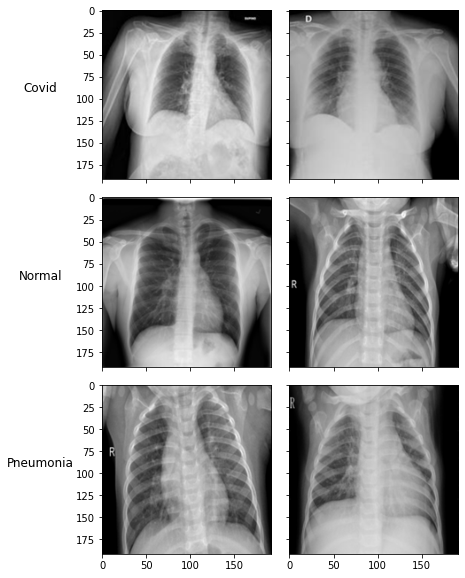

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor(fnames[0][0])
im2 =preprocessor(fnames[0][2])
im3 =preprocessor(fnames[1][2])
im4 =preprocessor(fnames[1][7])
im5 =preprocessor(fnames[2][7])
im6 =preprocessor(fnames[2][9])

rows = ['Covid', '', 'Normal', '', 'Pneumonia','']

fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4, im5, im6]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

for ax, row in zip(grid, rows):
    # Iterating over the grid returns the Axes.
    ax.set_ylabel(row, rotation=0, size='large', labelpad=35)

plt.show()

The figure above shows the differences between the three diagonoses side-by-side. One can observe that the degree of visibility can vary quite dramatically. For example, the pictures on the top left and botttom left are nearly indistinguishable from the images in the center row to an untrained eye. On the other hand, the image on the top right and bottom right show severe inflammation that is visually distiniguishable from the normal X-rays.

The idea here is to train a model that can pick up on all the minute differences between the covid and pneumonia X-rays and the normal X-rays, some of which might not even be perceptable to a trained eye. As such, the goal is to create a model that can accurately diagnose patients based on their X-rays.  



## Part 3: Create train/test split and save data

In [ ]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [ ]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [ ]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

#Save data
import pickle

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

#Save data
import pickle

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

# Restart session Runtime > Restart runtime

## Part 4: Create model 1

In [ ]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

In [ ]:
import tensorflow as tf

l1_l2_reg = tf.keras.regularizers.l1_l2(l1=0, l2=0)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=16, padding='same', activation='relu', kernel_regularizer=l1_l2_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', kernel_regularizer=l1_l2_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu', kernel_regularizer=l1_l2_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=48, padding='same', activation='relu', kernel_regularizer=l1_l2_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(kernel_size=1, filters=48, padding='same', activation='relu', kernel_regularizer=l1_l2_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu', kernel_regularizer=l1_l2_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu', kernel_regularizer=l1_l2_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=80, padding='same', activation='relu', kernel_regularizer=l1_l2_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(kernel_size=1, filters=80, padding='same', activation='relu', kernel_regularizer=l1_l2_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, epochs = 30, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/30
69/69 [==============================] - 25s 75ms/step - loss: 0.6430 - accuracy: 0.7920 - val_loss: 1.4965 - val_accuracy: 0.3406
Epoch 2/30
69/69 [==============================] - 3s 50ms/step - loss: 0.2737 - accuracy: 0.8960 - val_loss: 1.3887 - val_accuracy: 0.3479
Epoch 3/30
69/69 [==============================] - 4s 53ms/step - loss: 0.1576 - accuracy: 0.9343 - val_loss: 1.4239 - val_accuracy: 0.4554
Epoch 4/30
69/69 [==============================] - 4s 53ms/step - loss: 0.0844 - accuracy: 0.9726 - val_loss: 1.4230 - val_accuracy: 0.3206
Epoch 5/30
69/69 [==============================] - 4s 52ms/step - loss: 0.0508 - accuracy: 0.9831 - val_loss: 2.2881 - val_accuracy: 0.3206
Epoch 6/30
69/69 [==============================] - 4s 56ms/step - loss: 0.0237 - accuracy: 0.9964 - val_loss: 2.0414 - val_accuracy: 0.4080
Epoch 7/30
69/69 [==============================] - 4s 51ms/step - loss: 0.0146 - accuracy: 0.9977 - val_loss: 1.1722 - val_accuracy: 0.6466
Epoch 8/30
6

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 16)      272       
                                                                 
 batch_normalization (BatchN  (None, 192, 192, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 32)       1

In [ ]:
model.save("model1.h5", save_format="h5")

## Part 5: Create model 2

In [ ]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

In [ ]:
#Define fire module
import tensorflow as tf

# Create function to define fire modules
def fire(x, squeeze, expand):
  y = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x) 
  y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y) # note: //2 takes input value and divides by 2, so we reach the dimensions requested with stacking later.
  y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
  return tf.keras.layers.concatenate([y1, y3])

# this is to make it behave similarly to other Keras layers
def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

In [ ]:
#Using functional API
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  x = tf.keras.layers.Input(shape=[192,192, 3]) # input is 192x192 pixels RGB

  y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
  
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.GlobalAveragePooling2D()(y)
  y = tf.keras.layers.Dense(3, activation='softmax')(y)

  model = tf.keras.Model(x, y)

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 15, verbose=1,validation_split=.2)

Epoch 1/15
69/69 [==============================] - 15s 118ms/step - loss: 1.0936 - acc: 0.3691 - val_loss: 1.0795 - val_acc: 0.4189
Epoch 2/15
69/69 [==============================] - 6s 85ms/step - loss: 1.0530 - acc: 0.4571 - val_loss: 1.0629 - val_acc: 0.4044
Epoch 3/15
69/69 [==============================] - 6s 91ms/step - loss: 1.0247 - acc: 0.5014 - val_loss: 1.0070 - val_acc: 0.4809
Epoch 4/15
69/69 [==============================] - 6s 86ms/step - loss: 0.9324 - acc: 0.5903 - val_loss: 0.8307 - val_acc: 0.6721
Epoch 5/15
69/69 [==============================] - 6s 89ms/step - loss: 0.7363 - acc: 0.6843 - val_loss: 0.6780 - val_acc: 0.7031
Epoch 6/15
69/69 [==============================] - 6s 86ms/step - loss: 0.6644 - acc: 0.7062 - val_loss: 0.6538 - val_acc: 0.7104
Epoch 7/15
69/69 [==============================] - 7s 95ms/step - loss: 0.6582 - acc: 0.7007 - val_loss: 0.6362 - val_acc: 0.7177
Epoch 8/15
69/69 [==============================] - 6s 88ms/step - loss: 0.6370 -

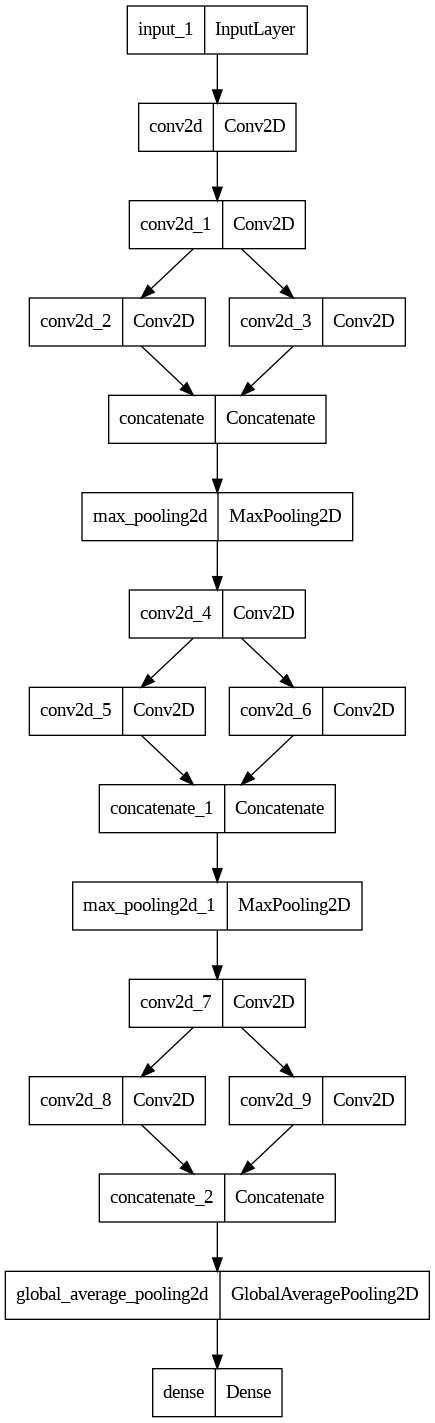

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 192, 192, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 192, 192, 24  792         ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
model.save("model2.h5", save_format="h5")

## Part 6: Create model 3

In [ ]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

In [ ]:
#Define fire module
import tensorflow as tf

# Create function to define fire modules
def fire(x, squeeze, expand):
  y = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x) 
  y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y) # note: //2 takes input value and divides by 2, so we reach the dimensions requested with stacking later.
  y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
  return tf.keras.layers.concatenate([y1, y3])

# this is to make it behave similarly to other Keras layers
def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

In [ ]:
#Using functional API
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  x = tf.keras.layers.Input(shape=[192,192, 3]) # input is 192x192 pixels RGB

  y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
  y = tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu')(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = tf.keras.layers.Conv2D(kernel_size=3, filters=48, padding='same', activation='relu')(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu')(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = tf.keras.layers.Conv2D(kernel_size=3, filters=80, padding='same', activation='relu')(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)

  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.GlobalAveragePooling2D()(y)
  y = tf.keras.layers.Dense(3, activation='softmax')(y)

  model = tf.keras.Model(x, y)

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 30, verbose=1,validation_split=.2)

Epoch 1/30
69/69 [==============================] - 16s 85ms/step - loss: 0.8883 - acc: 0.5474 - val_loss: 0.6997 - val_acc: 0.6630
Epoch 2/30
69/69 [==============================] - 4s 61ms/step - loss: 0.6329 - acc: 0.6971 - val_loss: 0.6917 - val_acc: 0.6849
Epoch 3/30
69/69 [==============================] - 4s 63ms/step - loss: 0.5921 - acc: 0.7354 - val_loss: 0.5551 - val_acc: 0.7541
Epoch 4/30
69/69 [==============================] - 4s 60ms/step - loss: 0.5472 - acc: 0.7623 - val_loss: 0.5408 - val_acc: 0.7577
Epoch 5/30
69/69 [==============================] - 4s 61ms/step - loss: 0.4972 - acc: 0.7787 - val_loss: 0.4330 - val_acc: 0.8087
Epoch 6/30
69/69 [==============================] - 4s 65ms/step - loss: 0.4572 - acc: 0.7943 - val_loss: 0.4701 - val_acc: 0.7960
Epoch 7/30
69/69 [==============================] - 4s 64ms/step - loss: 0.4264 - acc: 0.8152 - val_loss: 0.4751 - val_acc: 0.7923
Epoch 8/30
69/69 [==============================] - 4s 62ms/step - loss: 0.4297 - 

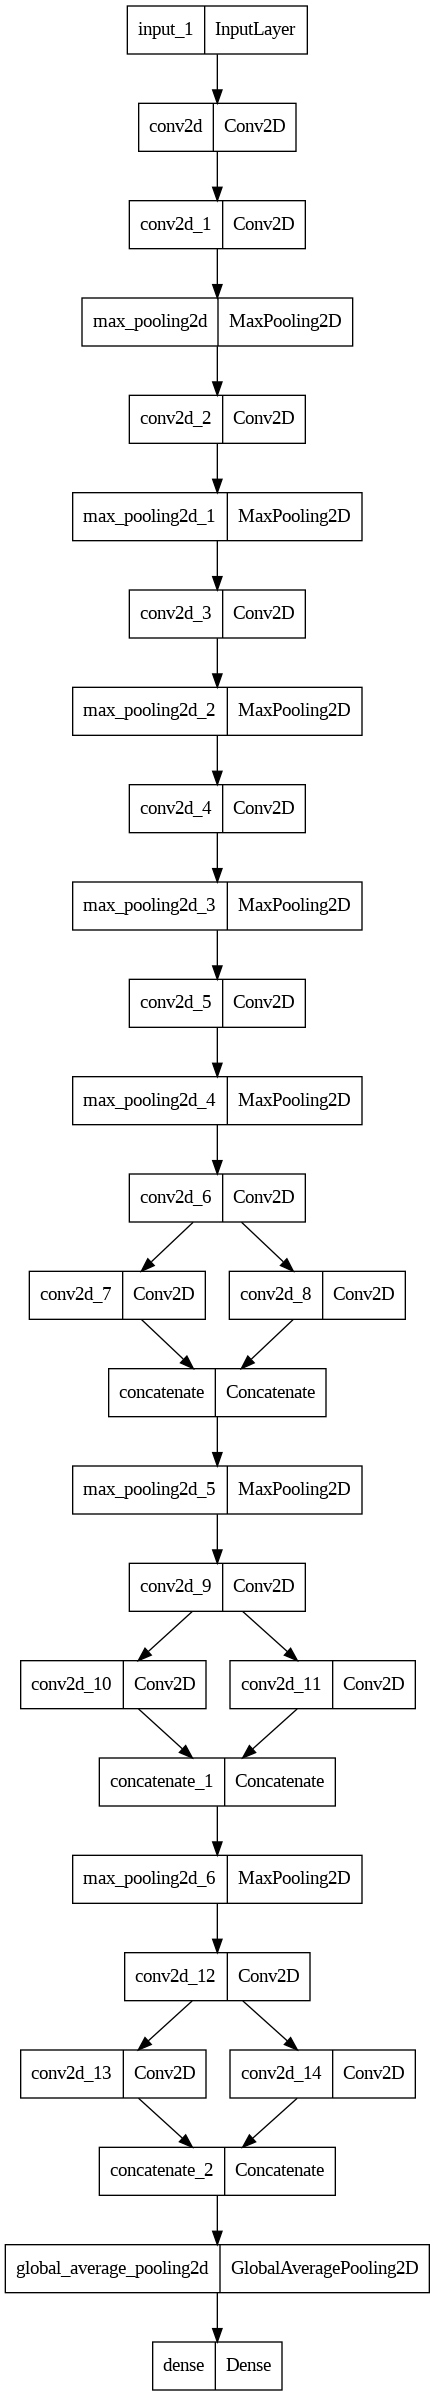

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 192, 192, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 192, 192, 16  4624        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
model.save("model3.h5", save_format="h5")

## Part 7: Create model 4 with transfer learning

In [ ]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(input_shape=(192,192,3), include_top=False, weights='imagenet')
base_model.trainable = False

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  y = tf.keras.layers.Flatten()(base_model.layers[-1].output)
  y = tf.keras.layers.Dense(160, activation='relu')(y)
  y = tf.keras.layers.Dense(80, activation='relu')(y)
  y = tf.keras.layers.Dropout(.5)(y)
  y = tf.keras.layers.Dense(3, activation='softmax')(y)

  model = tf.keras.Model(base_model.inputs, y)

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 15, verbose=1,validation_split=.2)
  

Epoch 1/15
69/69 [==============================] - 13s 118ms/step - loss: 2.9168 - acc: 0.6816 - val_loss: 0.3540 - val_acc: 0.8634
Epoch 2/15
69/69 [==============================] - 5s 75ms/step - loss: 0.5046 - acc: 0.7911 - val_loss: 0.3781 - val_acc: 0.8233
Epoch 3/15
69/69 [==============================] - 5s 73ms/step - loss: 0.4741 - acc: 0.8130 - val_loss: 0.2864 - val_acc: 0.8816
Epoch 4/15
69/69 [==============================] - 5s 76ms/step - loss: 0.3761 - acc: 0.8463 - val_loss: 0.2868 - val_acc: 0.9053
Epoch 5/15
69/69 [==============================] - 5s 75ms/step - loss: 0.3696 - acc: 0.8440 - val_loss: 0.3714 - val_acc: 0.8816
Epoch 6/15
69/69 [==============================] - 5s 73ms/step - loss: 0.3805 - acc: 0.8590 - val_loss: 0.2647 - val_acc: 0.8998
Epoch 7/15
69/69 [==============================] - 5s 72ms/step - loss: 0.3254 - acc: 0.8777 - val_loss: 0.2493 - val_acc: 0.8962
Epoch 8/15
69/69 [==============================] - 5s 76ms/step - loss: 0.2812 -

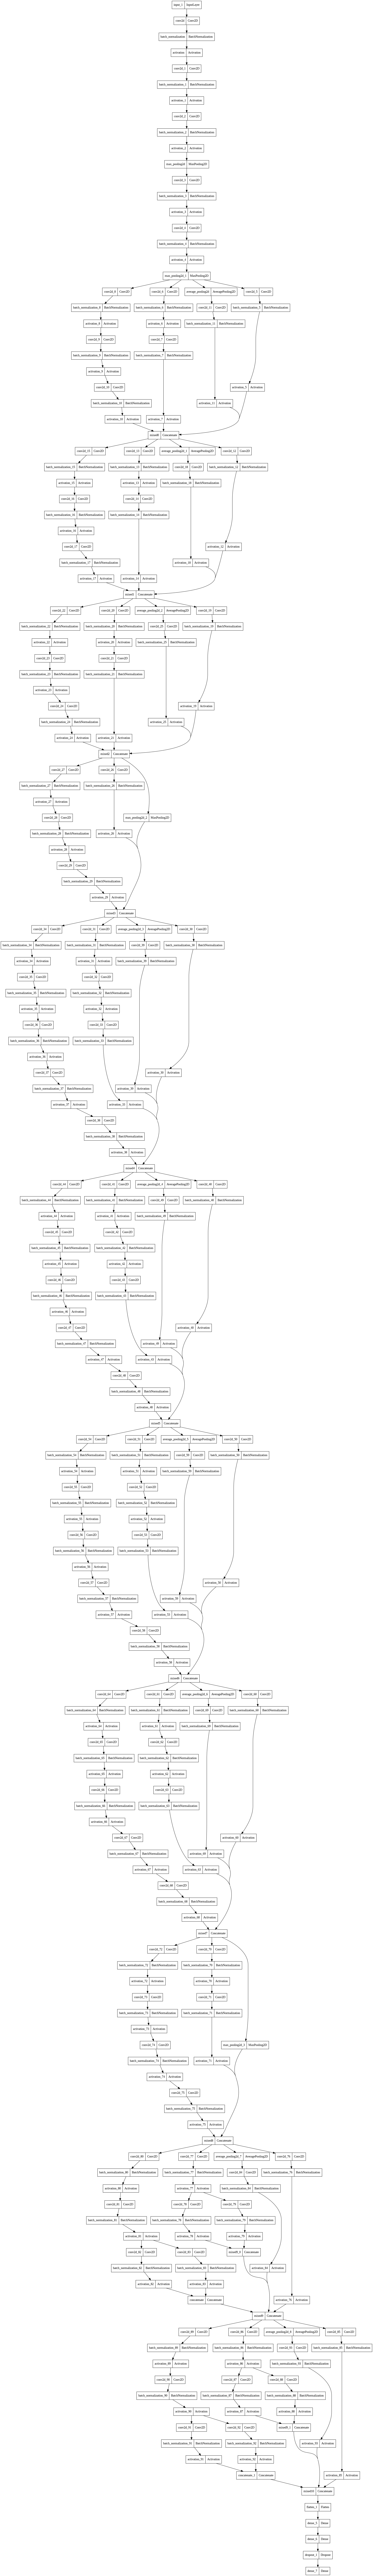

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [ ]:
model.save("model4.h5", save_format="h5")

## Part 8: Create model 5 with transfer learning

In [ ]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

In [ ]:
#Define fire module
import tensorflow as tf

# Create function to define fire modules
def fire(x, squeeze, expand):
  y = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x) 
  y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y) # note: //2 takes input value and divides by 2, so we reach the dimensions requested with stacking later.
  y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
  return tf.keras.layers.concatenate([y1, y3])

# this is to make it behave similarly to other Keras layers
def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(input_shape=(192,192,3), include_top=False, weights='imagenet')
base_model.trainable = False

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  y = tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu')(base_model.layers[-1].output)
  y = tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu')(y)
  y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(y)
  y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(y)
  y = tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu')(y)
  y = tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu')(y)
  y = tf.keras.layers.Conv2D(kernel_size=3, filters=80, padding='same', activation='relu')(y)
  y = tf.keras.layers.Conv2D(kernel_size=3, filters=80, padding='same', activation='relu')(y)

  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.GlobalAveragePooling2D()(y)
  y = tf.keras.layers.Dense(3, activation='softmax')(y)

  model = tf.keras.Model(base_model.inputs, y)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 30, verbose=1,validation_split=.2)
  

Epoch 1/30
69/69 [==============================] - 18s 134ms/step - loss: 0.7755 - acc: 0.5698 - val_loss: 0.5831 - val_acc: 0.6539
Epoch 2/30
69/69 [==============================] - 5s 74ms/step - loss: 0.5554 - acc: 0.6902 - val_loss: 0.4875 - val_acc: 0.8160
Epoch 3/30
69/69 [==============================] - 6s 84ms/step - loss: 0.4360 - acc: 0.8253 - val_loss: 0.3215 - val_acc: 0.8652
Epoch 4/30
69/69 [==============================] - 6s 86ms/step - loss: 0.3307 - acc: 0.8727 - val_loss: 0.3028 - val_acc: 0.8761
Epoch 5/30
69/69 [==============================] - 6s 84ms/step - loss: 0.3150 - acc: 0.8828 - val_loss: 0.3050 - val_acc: 0.8816
Epoch 6/30
69/69 [==============================] - 6s 80ms/step - loss: 0.2163 - acc: 0.9220 - val_loss: 0.2643 - val_acc: 0.8980
Epoch 7/30
69/69 [==============================] - 6s 81ms/step - loss: 0.1933 - acc: 0.9339 - val_loss: 0.3208 - val_acc: 0.8743
Epoch 8/30
69/69 [==============================] - 6s 87ms/step - loss: 0.1450 -

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [ ]:
model.save("model5.h5", save_format="h5")

## Part 9: Rerun best model with augmented data

In [ ]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train, test_size = 0.2, random_state = 1987)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

batch_size = 256

train_image_gen = image_gen.flow(X_train, y=y_train, batch_size=batch_size, shuffle=False)

In [ ]:
sample_training_images,_ = next(train_image_gen)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow((img * 255 / np.max(img)).astype('uint8'))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

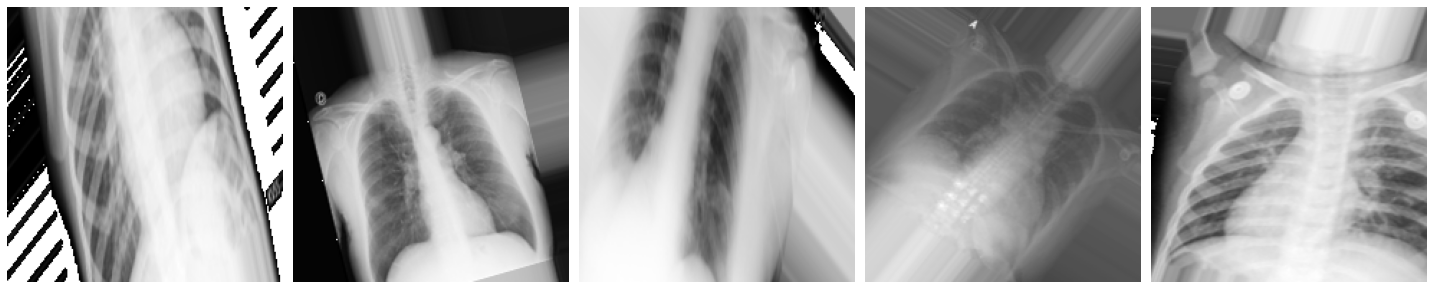

In [ ]:
plotImages(sample_training_images[:5])

In [ ]:
validation_image_generator = ImageDataGenerator(rescale=1./255)
val_image_gen = validation_image_generator.flow(X_val, y=y_val, batch_size=batch_size, shuffle=False)

In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model1.h5',compile=False)

In [ ]:
total_train = X_train.shape[0]
total_val = X_val.shape[0]

In [ ]:
# Using the flow method to feed in the data
with tf.device('/device:GPU:0'): 

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(train_image_gen,
            steps_per_epoch=total_train // batch_size,
            epochs = 30, 
            validation_data=val_image_gen,
            validation_steps=total_val // batch_size,
            verbose=1)

## Part 10: Submit best models to the AiModelShare leaderboard

In [ ]:
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade ##Only do this if needed
# Restart session Runtime > Restart runtime

In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model4.h5',compile=False)

model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

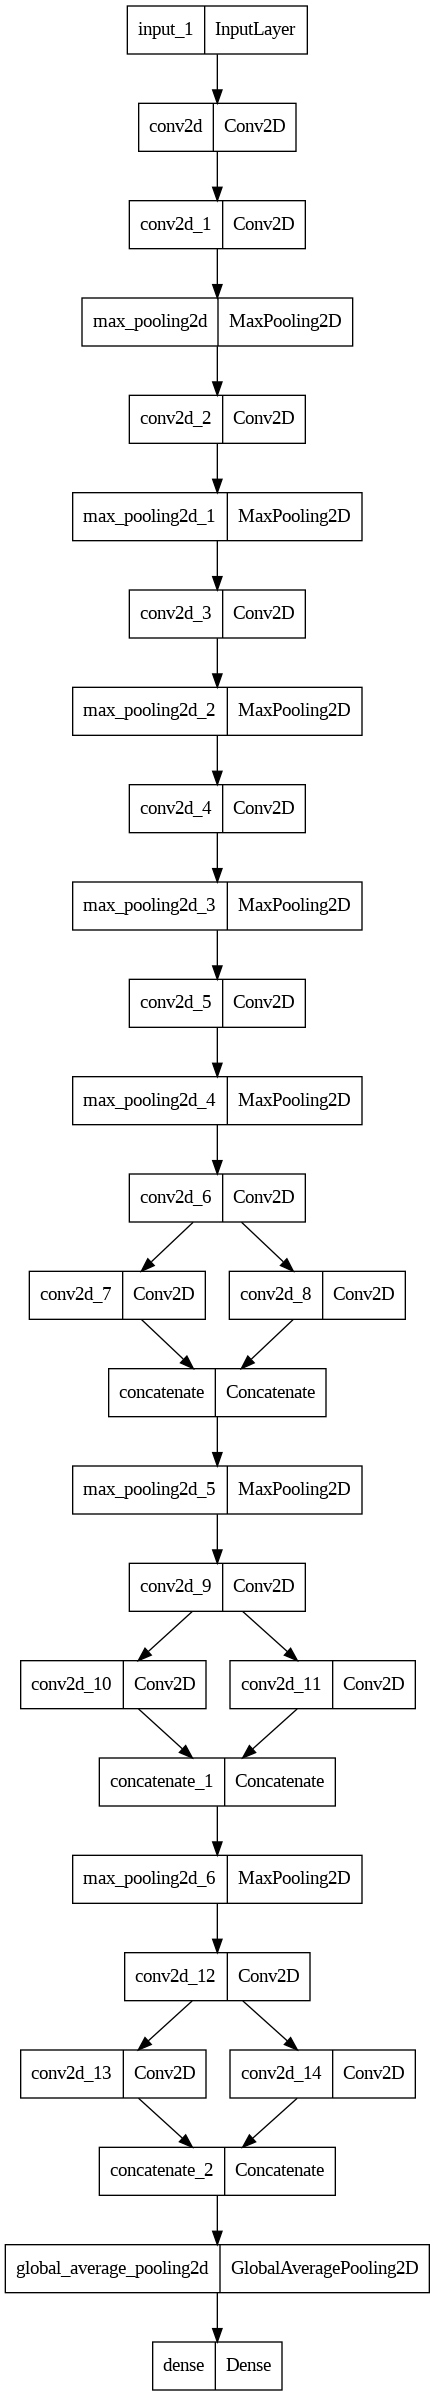

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 14s 70ms/step


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

## Results and discussion

The first model achieved a testing accuracy of 94.42% and thus performed best out of all the models that were used. The model was improved by batch normalization after every convolution layer. L1 and L2 regularization, on the other hand, worsened the model's performance uniliaterally. An interesting observation is that the batch normalization made the model take around twice the amount of epochs to converge and increased validation accuracy by a few percent.

The fire modules used in model 2 and 3 were sucessful, but even with many additional convolutional layers tacked on, model 3 was unable to beat the performance of model 1. Likely, the model could have benefitted from even more sophistication.

For the transfer learning with InceptionV3, two different approaches were taken. Model 4 only switches out a few dense layers at the end, whereas, model 5 adds an array of convolutional layers and some fire modules at the end. Interestingly, neither the simple nor the sophisticated transfer learning model are able to outperform model 1. 

The data augmentation adds rotation, shifts, flips, and zoom and is likely doing too much as it unilaterially decreased model performance.

To conculde, the most sucessful approach was the convolutional model used in model 1. Here the number of filters is gradually increased from 16 to 80 and the kernal size alternates btween 1 and 3. After each block of two convolutional layers there is also a max pooling layer with pool size 2. At the time of posting, this model was on the 8th place on the leaderboard.